M54 data - Part 2
=================

The general issue is that there is a certain discrepancy between:

- Our MAP estimate.
- The PPXF fit provided by the M54-data.
- Our PPXF fit.

First, we set up the data:

In [45]:
import numpy as np
import matplotlib.pyplot as plt
import uq4pk_src

m54_data = uq4pk_src.data.M54()
m54_data.logarithmically_resample(dv=50.)

ssps = uq4pk_src.model_grids.MilesSSP(
    miles_mod_directory='EMILES_BASTI_BASE_BI_FITS',
    imf_string='Ebi1.30',
    lmd_min=None,
    lmd_max=None,
    )
ssps.resample_spectra(m54_data.lmd)
# normalise the SSP templates to be light-weighted rather than mass-weighted,
ssps.Xw /= np.sum(ssps.Xw, 0)
ssps.dv = m54_data.dv
ssps.speed_of_light = m54_data.speed_of_light


Spectres: new_wavs contains values outside the range in spec_wavs, new_fluxes and new_errs will be filled with the value set in the 'fill' keyword argument. 



Let us look at the PPXF fit and ground truth provided with the M54 data.

Note that the orientation of the distribution function $f$ for the PPXF fit and our observation
operator is different from the correct orientation for visualisation. To make sure that we do not
get confused, I will denote the distribution function with ``f`` if it has the correct orientation
for the observation operator, and with ``im`` if it has the correct orientation for visualisation.

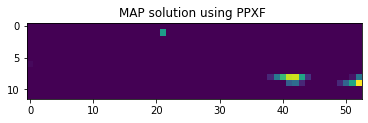

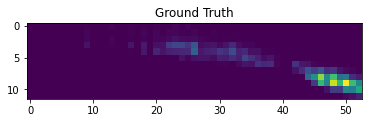

In [46]:
%matplotlib inline

def orient_image(f):
    """
    Transform the distribution function that goes into observation operator into an image
    that has the correct orientation for visualisation.
    """
    image = f
    # Have to flip.
    image = np.flipud(image)
    return image

f_ppxf_m54 = m54_data.ppxf_map_solution.T
im_ppxf_m54 = orient_image(f_ppxf_m54)
plt.imshow(im_ppxf_m54)
plt.gca().set_title('MAP solution using PPXF ')
plt.show()

# ground truth
f_ground_truth = m54_data.ground_truth.T
im_ground_truth = orient_image(f_ground_truth)
plt.imshow(im_ground_truth)
plt.gca().set_title('Ground Truth')
plt.show()

Recreating the PPXF fit
-----------------------

Next, we try to recreate ``f_ppxf_m54`` ourselves:

 Best Fit:       Vel     sigma        h3        h4
 comp.  0:       146         3    -0.008    -0.003
chi2/DOF: 1.143; degree = -1; mdegree = 10
method = capfit; Jac calls: 9; Func calls: 139; Status: 2
linear_method = lsq_box; Nonzero Templates (>0.1%):  4 / 636


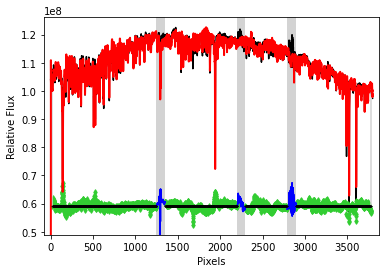

In [47]:
from ppxf import ppxf

npix_buffer_mask = 20
m54_data.mask[:npix_buffer_mask] = False
m54_data.mask[-npix_buffer_mask:] = False

templates = ssps.Xw
galaxy = m54_data.y
noise = m54_data.noise_level
velscale = ssps.dv
start = [0., 30., 0., 0.]
bounds = [[-500,500], [3,300.], [-0.3,0.3], [-0.3,0.3]]
moments = 4
mask = m54_data.mask

# final pixel is NAN, breaks PPXF even though this is masked, so remove it here manually
templates = templates[:-1,:]
galaxy = galaxy[:-1]
noise = noise[:-1]
mask = mask[:-1]

ppxf_fit = ppxf.ppxf(
    templates,
    galaxy,
    noise,
    velscale,
    start=start,
    degree=-1,
    mdegree=10,
    moments=moments,
    bounds=bounds,
    regul=0,
    mask=mask
)

ppxf_fit.plot()


Let's plot the distribution function:

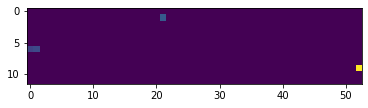

In [48]:
f_ppxf = np.reshape(ppxf_fit.weights, ssps.par_dims)
im_ppxf = orient_image(f_ppxf)
plt.imshow(im_ppxf)

I don't know about this. Our PPXF fit also has 3 clumps, but they are at significantly different positions than
in the M54-PPXF fit.


Compare to our MAP estimate
----------------------------

Finally, let's look at the fit using our observation operator:


First, correct the templates using the fitted polynomial:


In [49]:
continuum_distorition = ppxf_fit.mpoly
# add an extra element to the end of array to account for one that we chopped off earlier
continuum_distorition = np.concatenate([continuum_distorition, [continuum_distorition[-1]]])

import copy
ssps_corrected = copy.deepcopy(ssps)
ssps_corrected.Xw = (ssps_corrected.Xw.T * continuum_distorition).T
ssps_corrected.Xw /= np.sum(ssps_corrected.Xw, 0)

Let's adapt the observation operator:


In [50]:
from uq4pk_src.observation_operator import ObservationOperator
G = ObservationOperator(ssps=ssps_corrected,
                        dv=ssps_corrected.dv,
                        do_log_resample=False)

Distribution functions should have shape (12, 53)


We set $\theta_v$ equal to the PPXF fit. We have to invert the sign of $h_3$.

In [51]:
theta_v = np.array([146, 3, 1., 0., 0., 0.008, -0.003])

In [52]:
mask = m54_data.mask
y = m54_data.y[mask]
y_sd = m54_data.noise_level[mask]

Next, fit our model using the **corrected** observation operator.

But first, we check the scale of the ppxf fit:

In [53]:
ppxf_scale = np.linalg.norm(f_ppxf)
print(f"PPXF Scale = {ppxf_scale}")


PPXF Scale = 276718380338.35223


That is very large. Since the PPXF fit is
on such a giant scale, we do not fit $f$ directly but a rescaled parameter $g = \frac{1}{s} f$.
The reason for this is that the optimization routine assumes that $||f||$ is on a scale that is
 comparable to 1. As a scaling factor, we use:

In [54]:
s = ppxf_scale

With this, lets compute the MAP estimate for $g$.

Distribution functions should have shape (12, 53)




Starting the constrained Gauss-Newton method. Cost at starting value: 5283.943192276246
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.6782080042463247   |   4.54643917999209e-13  |    20.213260342822466   |           1.0           |    1.1329584121704102   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.6782080042463243   |  4.520

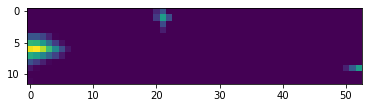

In [55]:
%matplotlib inline

from uq4pk_fit.inference import ForwardOperator, StatModel

# Rescale

y_scaled = y / s
y_sd_scaled = y_sd / s

forward_operator = ForwardOperator(hermite_order=4, mask=mask, ssps=ssps_corrected, dv=ssps_corrected.dv,
                                   do_log_resample=False)
# Fit the model
model = StatModel(y=y_scaled, y_sd=y_sd_scaled, forward_operator=forward_operator)
model.fix_theta_v(indices=np.arange(model.dim_theta), values=theta_v)
model.beta1 = 1.
fitted_model = model.fit()
g_map = fitted_model.f_map
f_map = s * g_map.clip(min=0.)  # Enforce nonnegativity
im_map = orient_image(f_map)
plt.imshow(im_map)

Let us compare this to both our ppxf fit and the one from the M54 data:

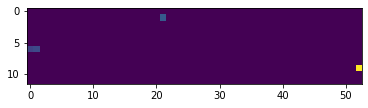

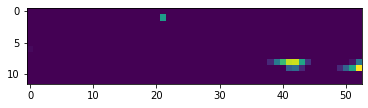

In [56]:
plt.imshow(im_ppxf)
plt.show()
plt.imshow(np.flipud(f_ppxf_m54))
plt.show()

Note that our MAP fit looks very similar to our PPXF fit, but not so much to the M54 fit.
To be able to compare the results, we rescale the ppxf-fit provided with the M54 data set
such that it has the same scale as our ppxf fit.

In [57]:
# Rescale M54-ppxf
f_ppxf_m54_scaled = f_ppxf_m54 / np.linalg.norm(f_ppxf_m54) * s

# Compute data fit
ydim = y.size
def data_fit(z):
    scaled_fit = np.linalg.norm((z - y) / y_sd) / ydim
    return scaled_fit

y_map = G.evaluate(f_map, theta_v)[mask]
y_ppxf = G.evaluate(f_ppxf, theta_v)[mask]
y_ppxf_m54 = G.evaluate(f_ppxf_m54_scaled, theta_v)[mask]
data_fit_map = data_fit(y_map)
data_fit_ppxf = data_fit(y_ppxf)
data_fit_ppxf_m54 = data_fit(y_ppxf_m54)
print(f"Data fit of MAP: {data_fit_map}")
print(f"Data fit of our PPXF: {data_fit_ppxf}")
print(f"Data fit of M54-PPXF: {data_fit_ppxf_m54}")

Data fit of MAP: 0.019381149490890592
Data fit of our PPXF: 1.669257531896089
Data fit of M54-PPXF: 1.3107496407746322


We observe:
 - Our MAP estimate has a much better data fit than the PPXF fit.
 - Also, our ppxf fit has a better data fit than the M54-PPXF fit, but this might easily be explained
 with the fact that we don't know the correct scale for the M54-PPXF fit, and also that it might be
 associated to a different fit for $\theta_v$.

Reproducing the PPXF fit with our optimization method
-----------------------------------------------------

In principle, if we turn off regularization, we should be able to recover the PPXF fit using our
implementation, since both should just be identical to the maximum likelihood estimate.

Let's test this.



Starting the constrained Gauss-Newton method. Cost at starting value: 5283.9431922687845
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
| Iteration | Cost                    | Constraint violation    | Stepsize (||p||)        | Steplength (h)          | Computation time [s]    |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     1     |    0.6250405989310639   |  1.740990609056664e-10  |    139.73615869385742   |           1.0           |    1.1517302989959717   |
+-----------+-------------------------+-------------------------+-------------------------+-------------------------+-------------------------+
|     2     |    0.6250405989310536   |  1.74

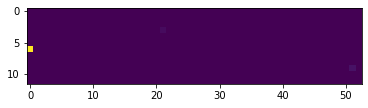

In [58]:
model.beta1 *= 1e-6

fitted_model_unregularized = model.fit()
g_ml = fitted_model_unregularized.f_map
f_ml = s * g_ml.clip(min=0.)
im_ml = orient_image(f_ml)
plt.imshow(im_ml)

This does not look quite like our PPXF fit:

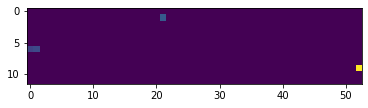

In [59]:
plt.imshow(im_ppxf)


Removing the regularization leads the reconstruction to be concentrated at the
rightmost of the three clumps. What might be the reason? Let's compare the data fits again.

In [60]:
y_ml = G.evaluate(f_ml, theta_v)[mask]
data_fit_ml = data_fit(y_ml)

print(f"Data fit without regularization: {data_fit_ml}")
print(f"Data fit of our PPXF fit: {data_fit_ppxf}")

Data fit without regularization: 0.01900488422460996
Data fit of our PPXF fit: 1.669257531896089


So, our maximum likelihood estimate has a much better data fit. It's also curious that our
*regularized* fit is much closer to our - unregularized - PPXF fit than our unregularized
maximum likelihood fit. Could this mean that there is still some hidden
regularization in the PPXF fit?

Anyway, lets save the 4 important images.


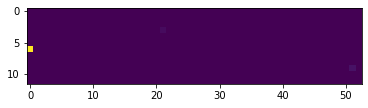

In [61]:
def save_image(im, name):
    plt.imshow(im)
    plt.savefig(name, bbox_inches="tight")

save_image(im_ppxf_m54, "im_ppxf_m54.png")
save_image(im_ppxf, "im_ppxf.png")
save_image(im_map, "im_map.png")
save_image(im_ml, "im_ml.png")

